### CryptoCurrency (BTC-USD) Forecasting

In [2]:
import tensorflow as tf
import os
import warnings 
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import meanabs, rmse
from statsmodels.tools.eval_measures import meanabs
from sklearn.preprocessing import MinMaxScaler
import gc
import math as mt
from IPython.display import display
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Data Extraction and Preprocessing | With 1 month data (1 minute unit-stick)  

In [3]:
df_asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
print('df_asset_details: ',df_asset_details.shape)
df_train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv').iloc[:350000] #~3 months worth of data-points
print('train_shape: ', df_train.shape)

df_asset_details:  (14, 3)
train_shape:  (350000, 10)


In [14]:
display(df_asset_details)

target_coins = ['Bitcoin', 'Ethereum', 'Binance Coin']

df_asset_dict = {k : v for k, v in zip(df_asset_details['Asset_Name'].values, df_asset_details['Asset_ID'].values)}
df_btc = df_train[df_train['Asset_ID'] == df_asset_dict[target_coins[0]]]
df_eth = df_train[df_train['Asset_ID'] == df_asset_dict[target_coins[1]]]
df_bnb = df_train[df_train['Asset_ID'] == df_asset_dict[target_coins[-1]]]

print('BTC-Len: ', len(df_btc), ', ETH-Len: ', len(df_eth), ', BNB-Len: ', len(df_bnb))

print()
display(df_btc.head(5))

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


BTC-Len:  44406 , ETH-Len:  44406 , BNB-Len:  44100



,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


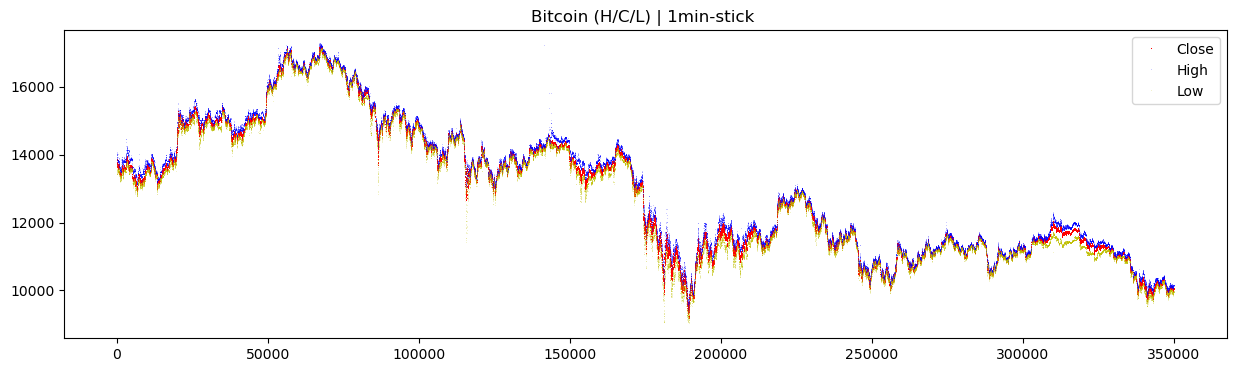

In [13]:
fig, axs = plt.subplots(1, 1, figsize = (15, 4))

axs.plot(df_btc.Close, ',r', label = 'Close')
axs.plot(df_btc.High, ',b', alpha = 0.2, label = 'High')
axs.plot(df_btc.Low, ',y', alpha = 0.2, label = 'Low')

axs.set_title(target_coins[0] + ' (H/C/L) | 1min-stick ')

plt.legend()
plt.show()

The prior slicing of the total sample size allows us to compare predictions with OOD close prices.

In [30]:
total_sample_size = len(df_btc)
print('total_sample_size: ', total_sample_size)

pred_sample_size = 5000
train_sample_size = total_sample_size - pred_sample_size

print('train_sample_size: ', train_sample_size, ', pred_sample_size: ', pred_sample_size)

total_sample_size:  44406
train_sample_size:  39406 , pred_sample_size:  5000


(39406, 10) (4999, 10)


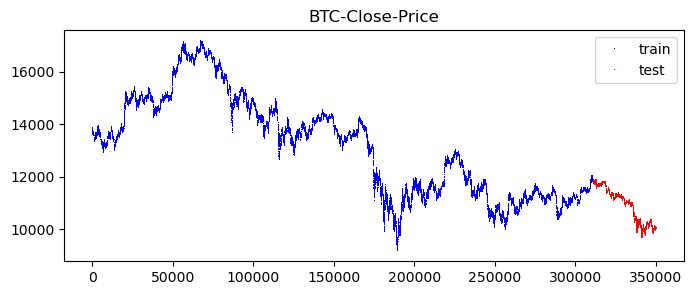

In [42]:
df_btc_train, df_btc_test = df_btc.iloc[:train_sample_size], df_btc.iloc[train_sample_size+1:]
print(df_btc_train.shape, df_btc_test.shape)

fig, axs = plt.subplots(1, 1, figsize = (8, 3))

axs.plot(df_btc_train.index, df_btc_train.Close, ',b', label = 'train')
axs.plot(df_btc_test.index, df_btc_test.Close, ',r', label = 'test')
axs.set_title('BTC-Close-Price')

plt.legend()
plt.show()

#### Custom-scaling

In [34]:
def min_max_scale(data, new):
    
    new_min, new_max = new
    
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)

    scaled_data = (data - min_values) * (new_max - new_min) / (max_values - min_values) + new_min

    return scaled_data, min_values, max_values

def descale(scaled_data, new_min, new_max):
    
    min_values = np.min(scaled_data, axis=0)
    max_values = np.max(scaled_data, axis=0)

    original_data = (scaled_data - min_values) * (new_max - new_min) / (max_values - min_values) + new_min
    
    return original_data

In [ ]:
x_obs = df_btc_train.Close.to_numpy()
x_obs_test = df_btc_test.Close.to_numpy()


train_split, test_split = 0.70, 0.30
train_max = round(train_split * x_obs.shape[0])
val_max = (1 - train_split) * x_obs.shape[0]
test_max = round(test_split * val_max)
val_max = round(val_max - test_max)

min: [-2.80583585], max: [1.93137701]
scaled-min: [0.], scaled-max: [1.]
Descaled:  9649.725 ,  11885.468333333334

train-shape:  (39406, 1) test-shape:  (4999, 1)


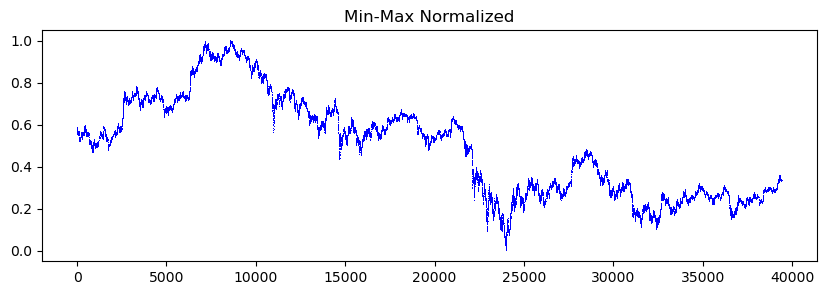

In [52]:
### Need to perform min-max scaling on the entire dataspace with the train_set distribution
### information only
### Assuming Lower Volatitly Levels for BTC

new = 0, 1

print(f'min: {min(x_train)}, max: {max(x_train)}')

x_obs_scaled, min_og, max_og = min_max_scale(x_train, new)
x_obs_scaled = x_obs_scaled.reshape(-1, 1)

x_obs_test_scaled, min_og, max_og = min_max_scale(x_obs_test, new)
x_obs_test_scaled = x_obs_test_scaled.reshape(-1, 1)

print(f'scaled-min: {min(x_obs_scaled)}, scaled-max: {max(x_obs_scaled)}')

x_obs_descaled = descale(x_obs_scaled, min_og, max_og)
print('Descaled: ', np.min(x_obs_descaled), ', ', np.max(x_obs_descaled))

print()
print('train-shape: ', x_obs_scaled.shape, 'test-shape: ', x_obs_test_scaled.shape)


fig, axs = plt.subplots(1, 1, figsize = (10, 3))

axs.plot(x_obs_scaled, ',b')
axs.set_title('Min-Max Normalized')

plt.show()

In [55]:
seed = 28
np.random.seed(seed)


def Data_func(data, past, delay, minn, maxx = None, shuffle=False, batch_size=128, rate=6):
    if maxx is None:
        maxx = len(data) - delay -1
    i = minn + past
    batch_no = 1

    while True:

        if shuffle:
            rows = np.random.randint(minn + past, maxx, size = batch_size)
        else:
            rows = np.arange(i, min(i + batch_size, maxx))
        
        i+=len(rows)
        if i + batch_size > maxx: ## when you increase the past too much this statement gets executed at the first batch creation // add more data to overcome
            break
        
        samples = np.zeros((len(rows), past // rate, data.shape[-1]))
        targets = np.zeros((len(rows),))
        cbase_preds = np.zeros((len(rows),))
    
        for j, row in enumerate(rows):
            
            indices = range(rows[j] - past, rows[j], rate) ## take every point
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay - 1][-1]
       
        if batch_no == 1:
            new_sample = samples
            new_targets = targets
            print('Ini_samples: ', samples.shape, 'Ini_targets: ', targets.shape)
        else:
            new_sample = np.concatenate([new_sample, samples], axis=0)
            new_targets = np.concatenate([new_targets, targets], axis=0)
        batch_no += 1
        
    return new_sample, new_targets

batch_size = 32
past = 360 #  6 hours in past {Localised}
delay = 15 # 15 minute diff into the future, no delay

## sampling data every 5 minute | Information Flow into the <val> and <test> set
train_data, train_target = Data_func(x_obs_scaled, past, delay, minn = 0, maxx = train_max - 1, batch_size = batch_size, shuffle=True, rate = 5)
val_data, val_target = Data_func(x_obs_scaled, past, delay, minn = train_max + 1, maxx = train_max + val_max - 1, batch_size = batch_size, rate = 5)
test_data, test_target = Data_func(x_obs_scaled, past, delay, minn = train_max + val_max + 1, maxx = train_max + val_max + test_max, batch_size = batch_size, rate = 5)

print()
print(train_data.shape, train_target.shape, val_data.shape, val_target.shape, test_data.shape, test_target.shape)
print('Min-Max-Range')
print(min(np.ravel(train_data)), max(np.ravel(train_target)))
print(min(np.ravel(val_data)), max(np.ravel(val_target)))
print(min(np.ravel(test_data)), max(np.ravel(test_target)))

Ini_samples:  (32, 72, 1) Ini_targets:  (32,)
Ini_samples:  (32, 72, 1) Ini_targets:  (32,)
Ini_samples:  (32, 72, 1) Ini_targets:  (32,)

(27168, 72, 1) (27168,) (7872, 72, 1) (7872,) (3136, 72, 1) (3136,)
Min-Max-Range
0.0 1.0
0.09997415193937288 0.4780048495409255
0.1448828148375613 0.3557785448770345


#### 2-Step PreProcessing - Normalization

In [ ]:
def inv_norm(test_target):
    test_target = np.ravel(test_target)
    test_target = test_target * std[-1]
    test_target = test_target + mean[-1]
    return test_target

NameError: name 'inv_norm' is not defined

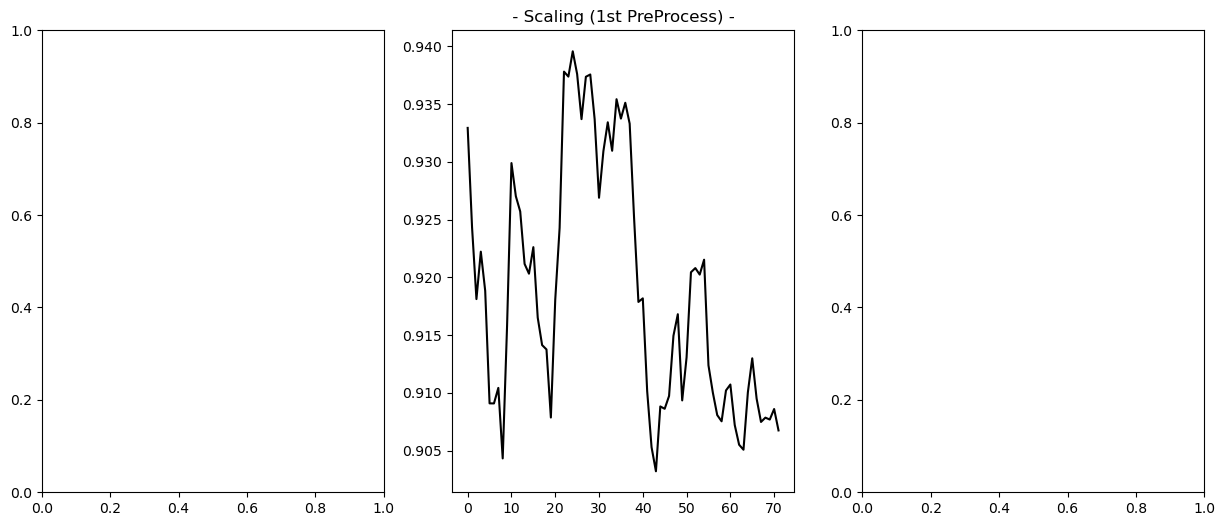

In [56]:
sample_seed = 5

fig, axs = plt.subplots(1, 3, figsize = (15, 6))

axs[1].plot(np.arange(0, len(train_data[sample_seed])), np.squeeze(train_data[sample_seed]), 'k')
axs[1].set_title(' - Scaling (1st PreProcess) - ')

axs[0].plot(np.arange(0, len(train_data[sample_seed])), inv_norm(np.squeeze(train_data[sample_seed])), 'k')
axs[0].set_title(' - Normalized (2nd PreProcess) - ')

axs[2].plot(np.arange(0, len(train_data[sample_seed])), descale(inv_norm(np.squeeze(train_data[sample_seed])), min_og, max_og), 'k')
axs[2].set_title(' - De-Scaled - ')

plt.tight_layout(pad = 2)
plt.show()

#### Structural-TS Workflow | Local-Linear-Trend <br>
TensorFlow (Exact) time-series implementation

In [ ]:
x_obs_scaled = x_obs_scaled[:200].reshape(-1, 1)
print(x_obs_scaled.shape)

In [ ]:
num_timesteps = len(x_obs_scaled)

def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(
      observed_time_series=approximate_unconstrained_rates)
    return tfp.sts.Sum([trend],
                     observed_time_series=approximate_unconstrained_rates)

positive_bijector = tfb.Softplus()  

approximate_unconstrained_rates = positive_bijector.inverse(tf.convert_to_tensor(x_obs_scaled))
sts_model = build_model(approximate_unconstrained_rates)

def sts_with_poisson_likelihood_model():
    # Encode the parameters of the STS model as random variables.
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)

    ''' WE yield only those R.V whose Joint-distrib we want to find'''    
        
    ## instantiate this model as a distribution over the given time-steps
    unconstrained_rate = yield sts_model.make_state_space_model(num_timesteps, param_vals)
    rate = positive_bijector.forward(unconstrained_rate[..., 0])
    obs = yield tfd.Poisson(rate, name='observed_counts')

model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)

In [ ]:
pinned_model = model.experimental_pin(observed_counts = x_obs_scaled)
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

In [ ]:
# Allow external control of sampling to reduce test runtimes.
num_results = 500 
num_results = int(num_results)

num_burnin_steps = 100 
num_burnin_steps = int(num_burnin_steps)

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tf.random.normal(part_shape)
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))

# Speed up sampling by tracing with `tf.function`.
# @tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=None)

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))


In [ ]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
    ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
    ax.plot(samples[i])
    ax.set_title("{} samples".format(param.name))

In [ ]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(x_obs_scaled, color="blue", ls='-', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 150), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 150), pred_lower, pred_upper, color='grey', label='obs', alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily Sample Size")
plt.title("Posterior Mean")
plt.legend()

Forecast

In [ ]:
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):

    # Forecast the future latent unconstrained rates, given the inferred latent
    # unconstrained rates and parameters.
    unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_model,
    observed_time_series=unconstrained_rate_samples,
    parameter_samples=posterior_params,
    num_steps_forecast=num_steps_forecast)

    # Transform the forecast to positive-valued Poisson rates.
    rates_forecast_dist = tfd.TransformedDistribution(
      unconstrained_rates_forecast_dist,
      positive_bijector)

    # Sample from the forecast model following the chain rule:
    # P(counts) = P(counts | latent_rates)P(latent_rates)
    sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
    sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

    return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)

forecast_samples = np.squeeze(forecast_samples)

In [ ]:
def plot_forecast_helper(data, forecast_samples, CI=90):
    
    plt.figure(figsize=(10, 4))
    forecast_median = np.median(forecast_samples, axis=0)

    num_steps = len(data)
    num_steps_forecast = forecast_median.shape[-1]

    plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='-', label='Observed Data', alpha=0.7)

    forecast_steps = np.arange(num_steps, num_steps+num_steps_forecast)

    CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

    plt.plot(forecast_steps, forecast_median, lw=2, ls='-', color='orange', label=str(CI) + '% Forecast Interval', alpha=0.7)
    plt.fill_between(forecast_steps,
                       lower,
                       upper, color='orange', alpha=0.2)

    plt.xlim([0, num_steps+num_steps_forecast])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
    yrange = ymax-ymin
    plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.ylim([0, max(x_obs_scaled) + 50])
    

In [ ]:
plot_forecast_helper(x_obs_scaled, forecast_samples, CI=20) # 20% Confidence-Interval for forecast
plt.plot((len(x_obs_scaled)) + np.arange(0, len(x_obs_test_scaled)), x_obs_test_scaled, 'r--', label = 'actual-forecast')
plt.legend()
plt.show()

----

#### Machine Learning Models (ANN and RNN)

ANN

In [ ]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(72,8)),
    tf.keras.layers.Dense(128, activation = 'linear'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1)
    
])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
dnn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
dnn_model.fit(tr_dataset, epochs=50, validation_data = val_dataset, validation_steps = val_steps, steps_per_epoch =128, callbacks=[es])
print('Training_Done ... ')

In [ ]:
print(dnn_model.evaluate(val_dataset, steps=128))
print(dnn_model.evaluate(test_dataset, steps=128)

In [ ]:
test_pred_data = [(sample, target) for sample, target in test_dataset.take(1)]
test_sample, test_target = test_pred_data[0] ## next 32 data-points | accounting for 32 mins prediction
x_lin = np.arange(0,test_target.shape[0]) 
def inv_norm(test_target):
    test_target = np.ravel(test_target)
    test_target = test_target * std[-1]
    test_target = test_target + mean[-1]
    return test_target

test_pred = dnn_model.predict(test_sample)
inv_test_pred = inv_norm(test_pred)
# test_pred_parent = inv_stdn(parent_model.predict(test_sample))
inv_test_target = inv_norm(test_target)

fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, inv_test_target, 'k', label = 'test')
plt.plot(x_lin, inv_test_pred, 'r',  label = 'dnn_model')
# plt.plot(x_lin, test_pred_parent, 'g', label = 'parent_model')
plt.legend()
plt.show()

RNN

In [ ]:
cnn_rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(72,8)),
    tf.keras.layers.Conv1D(128, 5),
    tf.keras.layers.Dense(264, activation='relu'),
    tf.keras.layers.GRU(264, return_sequences=True),
    tf.keras.layers.GRU(264),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
]) 

cnn_rnn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
cnn_rnn_model.summary()

es = tf.keras.callbacks.EarlyStopping(patience=5)
cnn_rnn_model.fit(tr_dataset, epochs=20, validation_data = val_dataset, validation_steps = val_steps, steps_per_epoch =128, callbacks=[es])
print('Training_Done...')

In [ ]:
cnn_rnn_model = tf.keras.models.load_model('../input/all-models/cnn_rnn_model.h5')

In [ ]:
print(cnn_rnn_model.evaluate(val_dataset, steps=128))
print(cnn_rnn_model.evaluate(test_dataset, steps=128))

In [ ]:
test_pred_data = [(sample, target) for sample, target in test_dataset.take(1)]
test_sample, test_target = test_pred_data[0] ##after validation set => next 32 datapoints | accounting for next 32 min prediction
x_lin = np.arange(0,test_target.shape[0]) 
def inv_norm(test_target):
    test_target = np.ravel(test_target)
    test_target = test_target * std[-1]
    test_target = test_target + mean[-1]
    return test_target

test_pred = cnn_rnn_model.predict(test_sample)
inv_test_pred = inv_norm(test_pred)
# test_pred_parent = inv_stdn(parent_model.predict(test_sample))
inv_test_target = inv_norm(test_target)

fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, inv_test_target, 'k', label = 'test')
plt.plot(x_lin, inv_test_pred, 'r',  label = 'dnn_model')
# plt.plot(x_lin, test_pred_parent, 'g', label = 'parent_model')
plt.legend()
plt.show()

In [ ]:
print('MAE: $ ' + str(meanabs(inv_test_target, inv_test_pred)))
print('Mean_target: $ ' + str(np.mean(inv_test_target)))
print('Mean_P_Error: ', (meanabs(inv_test_target, inv_test_pred) / np.mean(inv_test_target)) * 100, '%')

------------------------

### BNN Workflow

In [57]:
hidden_units = [32, 16]
learning_rate = 0.001  
dataset_size = len(x_obs_scaled)
batch_size = 32

In [58]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
        ]
    )
    return prior_model


def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            ## Student-t might be a better choice
            tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [59]:
def NLL(targets, est_distrib):
    return - est_distrib.log_prob(targets)

In [60]:
det_units = [128, 64, 64, 32]


def create_bnn_model(train_size):

    inputs = tf.keras.layers.Input(shape = train_data.shape[1:])
    x = tf.keras.layers.Dense(det_units[0], activation = 'tanh')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GRU(det_units[1], activation = 'tanh', return_sequences = True)(x)
    x = tf.keras.layers.LayerNormalization()(x)    
    x = tf.keras.layers.GRU(det_units[2], activation = 'tanh', return_sequences = False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(det_units[-1], activation = 'sigmoid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        x = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight = 1 / train_size,
            activation="sigmoid",
        )(x)

    # The output is deterministic: a single point estimate | Distribution.
    ''' Distrib. Output | Independent Normal (Gaussian) distributions for each element in the data '''
#     x = tf.keras.layers.Dense(units=2)(x) # |meu, Sigma| --> N_distrib 
#     outputs = tfp.layers.IndependentNormal(1)(x)

    ''' Deterministic Output '''
    outputs = tf.keras.layers.Dense(units=1)(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_target)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_target)).batch(batch_size)
tf.print(train_dataset, val_dataset)

loss = tf.keras.losses.MSE

bnn_model = create_bnn_model(dataset_size)
bnn_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss = loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

bnn_model.summary()

<_BatchDataset element_spec=(TensorSpec(shape=(None, 72, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 72, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 1)]           0         
                                                                 
 dense (Dense)               (None, 72, 128)           256       
                                                                 
 batch_normalization (BatchN  (None, 72, 128)          512       
 ormalization)                                                   
                                                                 
 gru (GRU)                   (None, 72, 64)            37248     
                             

In [61]:
num_epochs = 30

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

print("Start training the model...")

ft = time.time()

hist_values = bnn_model.fit(train_dataset, 
              epochs=num_epochs, 
             validation_data = val_dataset,
             callbacks = [es]
             )

lt = time.time()
print(f"Model training finished in {(lt - ft) / 60} mins")

Start training the model...
Epoch 1/30
130/849 [===>..........................] - ETA: 1:12 - loss: 1.7918 - root_mean_squared_error: 1.3368

KeyboardInterrupt: 

### Point-Estimate

In [ ]:
data_dict = {}

data_dict['train'] = [train_data, train_target]
data_dict['val'] = [val_data, val_target]
data_dict['test'] = [test_data, test_target]

In [ ]:

_rate = 300

def Pred_Plot(pred_data, pred_target):

    _ran = min(len(pred_data), 300)
    
    iterations = 10
    
    x_lin = np.arange(0, _ran) 

    predicted = []
    for _ in range(iterations):
        predicted.append(bnn_model(pred_data[:_ran]).numpy())
    predicted = np.concatenate(predicted, axis=1)
    _st = 3
    predicted_three = predicted[:, _st : _st + (_rate//100)] 
    
    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()


    inv_test_pred = inv_norm(prediction_mean)
    inv_test_target = inv_norm(pred_target[:_ran])
    lower = inv_norm(prediction_min)
    upper = inv_norm(prediction_max)
    predicted_three = inv_norm(predicted_three)

    return x_lin, inv_test_pred, inv_test_target, lower, upper, predicted_three


fig, axs = plt.subplots(1, 2, figsize=(20,5))

names = list(data_dict.keys())

ft = time.time()

_color = ['blue', 'green', 'yellow']

for i, nm in enumerate(names[1:]):
    
    k_st = 0
    x_lin, inv_p, inv_t, lower, upper, p_three = Pred_Plot(data_dict[nm][0], data_dict[nm][-1])
    
    inv_t = descale(inv_t, min_og, max_og)
    inv_p = descale(inv_p, min_og, max_og)
    lower = descale(lower, min_og, max_og)
    upper = descale(upper, min_og, max_og)
    p_three = descale(p_three, min_og, max_og)
    
    axs[i].plot(x_lin, inv_t, 'k', label = 'target')
    axs[i].plot(x_lin, inv_p, 'r--',  label = 'Prediction (BNN)')
    for c in _color:
        axs[i].plot(x_lin, p_three[k_st: k_st + _rate], color = c, alpha = 0.2, label = 'Stoch. Components')
        k_st += _rate
    axs[i].fill_between(x_lin, lower, upper, color='orange', alpha=0.4, label = 'min-max range')
    axs[i].set_title(nm)
    axs[i].legend()
    
lt = time.time()
 
print('time-taken: ', (lt - ft)/60, 'mins')

plt.tight_layout(pad = 2)
plt.show()

### Probabilistic

In [ ]:
pred_data = test_data
pred_target = test_target
ci = 0.675

_ran = min(len(pred_data), 500)

x_lin = np.arange(0, _ran) 

## Just samples a value at each t from the surrogate posterior distrb.
prediction_distribution = bnn_model(pred_data[:_ran]) ### Gives stochastic value at each time-step (i,e n random variables for n t-steps) for each run
prediction_mean = prediction_distribution.mean().numpy().tolist() ### We get a distribution object, giving seperate distributions for each-time step  
prediction_stdv = prediction_distribution.stddev().numpy()

inv_test_pred = inv_norm(prediction_mean)
inv_test_target = inv_norm(pred_target[:_ran])

inv_test_pred = descale(inv_test_pred, min_og, max_og)
inv_test_target = descale(inv_test_target, min_og, max_og)


# The 75% CI 
upper = (prediction_mean + (ci * prediction_stdv)).tolist()
lower = (prediction_mean - (ci * prediction_stdv)).tolist()

upper = descale(upper, min_og, max_og)
lower = descale(lower, min_og, max_og)

fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, inv_test_target, 'k', label = 'test')
plt.plot(x_lin, inv_test_pred, 'r--',  label = 'Prediction (BNN)')
plt.fill_between(x_lin, inv_norm(lower), inv_norm(upper), color='orange', alpha=0.2, label = '75% CI')
plt.title('Test-Performance')

plt.legend()
plt.show()

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_target))
mse_error, rmse_error = bnn_model.evaluate(test_data, test_target)

print("MSE-Error (normalized): ", mse_error, ", RMSE-Error (normalized):",rmse_error)

---

SESSION STOPPER

In [ ]:
import time
for i in range(50):
    print('Time: ', i)
    time.sleep(30*60)